# Initial Model TFLite

This is the test notebook for the inital model that we will be using for the project.
There will be a lot of changes to this model as we go on, and we will be using this notebook to test those changes.


## Setup Environment


Mac Environment Setup:

1. Create a new virtual environment with Python 3.10. Do not use the setup_env.sh script.

- `python3.10 -m venv .venv`
- `source .venv/bin/activate`
- `pip install -r requirements.txt`

2. Verify that TensorFlow is working with the GPU.

- Check the output of the following cell. You should see something like:
  - TensorFlow version: 2.16.2
  - Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
  - Result: tf.Tensor([5. 7. 9.], shape=(3,), dtype=float32)
  - Metal device set to: Apple M1 Pro
  - systemMemory: 16.00 GB
  - maxCacheSize: 5.33 GB


In [1]:
# Initial Model TFLite

## Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.callbacks import TensorBoard
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import Video
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import os
import json
import shutil
import glob
import random
import math
import pydot
import graphviz
import datetime

# Verify TensorFlow installation
print(f"TensorFlow version: {tf.__version__}")

# Enable verbose logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

# Check GPU devices
gpus = tf.config.list_physical_devices("GPU")
print("Available GPUs:", gpus)

# Perform a computation
with tf.device("/GPU:0"):
    a = tf.constant([1.0, 2.0, 3.0])
    b = tf.constant([4.0, 5.0, 6.0])
    c = a + b
    print("Result:", c)


# The first time this cell is run, make sure that you see:
# Metal device set to: Apple M[GPU]

TensorFlow version: 2.16.2
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Result: tf.Tensor([5. 7. 9.], shape=(3,), dtype=float32)


2024-12-08 17:55:29.571473: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-08 17:55:29.571526: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-08 17:55:29.571540: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-08 17:55:29.571580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-08 17:55:29.571594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# Setup directories and filenames
NOTEBOOK_TAG = "initial_model"
MODEL_NAME = "rep_mate.keras"

MODELS_DIR = NOTEBOOK_TAG + "/models"
DATASET_DIR = NOTEBOOK_TAG + "/dataset"
CHKPT_DIR = NOTEBOOK_TAG + "/checkpoints"
LOG_DIR = NOTEBOOK_TAG + "/logs"
PLOT_DIR = "plots"
ANIM_DIR = "anim"

# Create base directories with parents
for directory in [MODELS_DIR, DATASET_DIR, CHKPT_DIR, PLOT_DIR]:
    os.makedirs(directory, exist_ok=True)

# Define model filenames
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME)
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME + "_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME + ".tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, MODEL_NAME + ".cc")

# Define dataset directories
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")

# Create dataset subdirectories
for directory in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(directory, exist_ok=True)

In [3]:
CLEAR_DATA = True

# Directories to clean up
DIRS = [
    MODELS_DIR,
    DATASET_DIR,
    CHKPT_DIR,
    TRAIN_DIR,
    VAL_DIR,
    TEST_DIR,
    LOG_DIR,
    CHKPT_DIR,
]


def remove_files_in_directory(directory):
    if not os.path.exists(directory):
        return

    for root, dirs, files in os.walk(directory, topdown=False):
        for name in files:
            file_path = os.path.join(root, name)
            try:
                os.unlink(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")


def cleanup_all_files(dirs=DIRS):
    print(
        "WARNING: This will delete all files in the following directories and their subdirectories:"
    )
    for dir in dirs:
        if os.path.exists(dir):
            total_files = sum([len(files) for _, _, files in os.walk(dir)])
            print(f"  - {dir} ({total_files} files)")

    confirmation = input("\nType 'YES' to confirm deletion: ")

    if confirmation == "YES":
        for directory in dirs:
            if os.path.exists(directory):
                remove_files_in_directory(directory)
                print(f"Removed files from: {directory}")
        print("\nAll files have been removed while preserving directory structure.")
    else:
        print("\nOperation cancelled.")


if CLEAR_DATA:
    cleanup_all_files(DIRS)

  - initial_model/models (6 files)
  - initial_model/dataset (299 files)
  - initial_model/checkpoints (21 files)
  - initial_model/dataset/train (0 files)
  - initial_model/dataset/validation (0 files)
  - initial_model/dataset/test (0 files)
  - initial_model/logs (2 files)
  - initial_model/checkpoints (21 files)
Removed files from: initial_model/models
Removed files from: initial_model/dataset
Removed files from: initial_model/checkpoints
Removed files from: initial_model/dataset/train
Removed files from: initial_model/dataset/validation
Removed files from: initial_model/dataset/test
Removed files from: initial_model/logs
Removed files from: initial_model/checkpoints

All files have been removed while preserving directory structure.


## Import Dataset


In [4]:
# Copy all files from data into notebook dataset directory
!cp -r ../data/* {DATASET_DIR}

# Get all the files in the dataset directory
DATASET_FILES = glob.glob(os.path.join(DATASET_DIR, "*", "*", "*"))

# Print the number of files in the dataset
print(f"Number of files in dataset: {len(DATASET_FILES)}")


Number of files in dataset: 298


In [5]:
# Python list to hold the dataset
DATASET = []

# Read each file and append to the dataset, add filename to the file data
for f in DATASET_FILES:
    with open(f, "r") as file:
        f_c = file.read()
    f_d = json.loads(f_c)
    f_d["filename"] = f
    DATASET.append(f_d)

print(f"Number of files in dataset: {len(DATASET)}")

Number of files in dataset: 298


## Visualize Dataset


In [6]:
def set_matplotlib_backend(backend="inline"):
    """
    Switch matplotlib backend between 'inline' and 'notebook'
    Args:
        backend (str): Either 'inline' (static plots) or 'notebook' (interactive/animations)
    """
    from IPython import get_ipython

    ipython = get_ipython()
    ipython.run_line_magic("matplotlib", backend)

In [7]:
LIFT_NAMES = {"dC": "Dumbbell Curl", "bP": "Bench Press", "dF": "Dumbbell Fly"}
LIFT_CLASSES = {
    "p_f": "Perfect Form",
    "l_i": "Lift Instability",
    "p_m": "Partial Motion",
    "o_a": "Off-Axis",
    "s_w": "Swinging Weight",
    "n_l": "No Lift",
}

In [8]:
def create_lists(data):
    time, aX, aY, aZ, gX, gY, gZ = [], [], [], [], [], [], []
    for v in data:
        time.append(v["t"])
        aX.append(v["aX"])
        aY.append(v["aY"])
        aZ.append(v["aZ"])
        gX.append(v["gX"])
        gY.append(v["gY"])
        gZ.append(v["gZ"])
    return time, aX, aY, aZ, gX, gY, gZ


def plot_flat_dataset(data, show=True, save=False):
    set_matplotlib_backend("inline")
    d = data["tSD"]
    lN = data["lN"]
    lC = data["lC"]
    time, aX, aY, aZ, gX, gY, gZ = create_lists(d)

    # Create subplots for acceleration and gyroscope data
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Acceleration subplot
    axs[0].plot(time, aX, label="Ax")
    axs[0].plot(time, aY, label="Ay")
    axs[0].plot(time, aZ, label="Az")
    axs[0].set_title("3D Acceleration Over Time")
    axs[0].set_ylabel("Acceleration (m/s^2)")
    axs[0].legend()

    # Gyroscope subplot
    axs[1].plot(time, gX, label="Gx")
    axs[1].plot(time, gY, label="Gy")
    axs[1].plot(time, gZ, label="Gz")
    axs[1].set_title("3D Gyroscope Over Time")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Gyroscope (rad/s)")
    axs[1].legend()

    # Set Chart Title
    fig.suptitle(f"{LIFT_NAMES[lN]} - {LIFT_CLASSES[lC]}", fontsize=16)

    # Show the plots
    plt.tight_layout()
    if show:
        plt.show()

    if save:
        fig.savefig(f"{PLOT_DIR}/{LIFT_NAMES[lN]}_{LIFT_CLASSES[lC]}_flat.png")


def plot_3d_trajectory(data, show=True, save=False):
    set_matplotlib_backend("inline")
    d = data["tSD"]
    lN = data["lN"]
    lC = data["lC"]
    time, aX, aY, aZ, gX, gY, gZ = create_lists(d)

    # Normalize time for color gradient
    norm_time = (np.array(time) - min(time)) / (max(time) - min(time))

    # Create 3D scatter plot for acceleration
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121, projection="3d")
    scatter = ax.scatter(aX, aY, aZ, c=norm_time, cmap="viridis", s=10)
    ax.plot(aX, aY, aZ, color="gray", alpha=0.5)  # Optional trajectory line
    ax.set_title("3D Acceleration Trajectory")
    ax.set_xlabel("Ax (m/s^2)")
    ax.set_ylabel("Ay (m/s^2)")
    ax.set_zlabel("Az (m/s^2)")
    fig.colorbar(scatter, ax=ax, label="Time Gradient")

    # Create 3D scatter plot for gyroscope
    ax2 = fig.add_subplot(122, projection="3d")
    scatter2 = ax2.scatter(gX, gY, gZ, c=norm_time, cmap="plasma", s=10)
    ax2.plot(gX, gY, gZ, color="gray", alpha=0.5)  # Optional trajectory line
    ax2.set_title("3D Gyroscope Trajectory")
    ax2.set_xlabel("Gx (rad/s)")
    ax2.set_ylabel("Gy (rad/s)")
    ax2.set_zlabel("Gz (rad/s)")
    fig.colorbar(scatter2, ax=ax2, label="Time Gradient")

    # Set Chart Title
    fig.suptitle(f"{LIFT_NAMES[lN]} - {LIFT_CLASSES[lC]}", fontsize=16)

    # Show the plot
    plt.tight_layout()
    if show:
        plt.show()

    if save:
        fig.savefig(f"{PLOT_DIR}/{LIFT_NAMES[lN]}_{LIFT_CLASSES[lC]}_3d.png")

In [9]:

def animate_3d_trajectory(data, filename, duration_factor=1):
    set_matplotlib_backend("notebook")
    d = data["tSD"]
    lN = data["lN"]
    lC = data["lC"]
    time, aX, aY, aZ, gX, gY, gZ = create_lists(d)

    # Duration and timing
    base_duration = 5  # Base duration in seconds
    total_duration = base_duration * duration_factor
    interval = (total_duration * 1000) / len(time)  # Interval in milliseconds

    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(131, projection="3d")  # Acceleration
    ax2 = fig.add_subplot(132, projection="3d")  # Gyroscope
    ax3 = fig.add_subplot(133, projection="3d")  # Position

    # Set axis limits dynamically to encompass all data
    buffer = 0.1  # Add a 10% buffer for better visibility
    ax.set_xlim([min(aX) - buffer, max(aX) + buffer])
    ax.set_ylim([min(aY) - buffer, max(aY) + buffer])
    ax.set_zlim([min(aZ) - buffer, max(aZ) + buffer])

    ax2.set_xlim([min(gX) - buffer, max(gX) + buffer])
    ax2.set_ylim([min(gY) - buffer, max(gY) + buffer])
    ax2.set_zlim([min(gZ) - buffer, max(gZ) + buffer])

    # Styling for Acceleration
    scatter_acc = ax.scatter([], [], [], c=[], cmap="viridis", s=100)
    (trajectory_acc,) = ax.plot([], [], [], color="blue", alpha=0.6, linewidth=2)
    ax.grid(True)
    ax.set_title("3D Acceleration Animation", fontsize=14)
    ax.set_xlabel("Ax (m/s^2)", fontsize=12)
    ax.set_ylabel("Ay (m/s^2)", fontsize=12)
    ax.set_zlabel("Az (m/s^2)", fontsize=12)

    # Styling for Gyroscope
    scatter_gyro = ax2.scatter([], [], [], c=[], cmap="plasma", s=100)
    (trajectory_gyro,) = ax2.plot([], [], [], color="red", alpha=0.6, linewidth=2)
    ax2.grid(True)
    ax2.set_title("3D Gyroscope Animation", fontsize=14)
    ax2.set_xlabel("Gx (rad/s)", fontsize=12)
    ax2.set_ylabel("Gy (rad/s)", fontsize=12)
    ax2.set_zlabel("Gz (rad/s)", fontsize=12)

    # Set Chart Title
    fig.suptitle(f"{LIFT_NAMES[lN]} - {LIFT_CLASSES[lC]}", fontsize=16)

    def init():
        scatter_acc.set_offsets(np.empty((0, 3)))
        scatter_gyro.set_offsets(np.empty((0, 3)))
        trajectory_acc.set_data([], [])
        trajectory_acc.set_3d_properties([])
        trajectory_gyro.set_data([], [])
        trajectory_gyro.set_3d_properties([])

        return (
            scatter_acc,
            scatter_gyro,
            trajectory_acc,
            trajectory_gyro,
        )

    def update(frame):
        # Acceleration
        x_acc, y_acc, z_acc = aX[: frame + 1], aY[: frame + 1], aZ[: frame + 1]
        scatter_acc._offsets3d = (x_acc, y_acc, z_acc)
        trajectory_acc.set_data(x_acc, y_acc)
        trajectory_acc.set_3d_properties(z_acc)

        # Gyroscope
        x_gyro, y_gyro, z_gyro = gX[: frame + 1], gY[: frame + 1], gZ[: frame + 1]
        scatter_gyro._offsets3d = (x_gyro, y_gyro, z_gyro)
        trajectory_gyro.set_data(x_gyro, y_gyro)
        trajectory_gyro.set_3d_properties(z_gyro)

        return (
            scatter_acc,
            scatter_gyro,
            trajectory_acc,
            trajectory_gyro
        )

    ani = FuncAnimation(
        fig, update, frames=len(time), init_func=init, blit=False, interval=interval
    )

    # Save the animation
    ani.save(filename, writer="ffmpeg", fps=1000 // interval)
    print(f"Animation saved as {filename}")

In [10]:
# Check if the directory already exists
if not os.path.exists(ANIM_DIR):
    try:
        # Create the directory
        os.makedirs(ANIM_DIR)
        print(f"Directory '{ANIM_DIR}' created successfully.")
    except Exception as e:
        # Handle any exceptions that occur during directory creation
        print(f"Error creating directory '{ANIM_DIR}': {e}")
else:
    print(f"Directory '{ANIM_DIR}' already exists.")

Directory 'anim' already exists.


In [11]:
# 16: Lift Instability
# 28: Swinging Weight
# 55: Off-Axis
# 99: Partial Motion
# 221: No Lift
# 231: Perfect Form
SAVE = False
if SAVE:
    for i in [16, 28, 55, 99, 221, 231]:
        data = DATASET[i]
        EXT = ".mp4"
        anim_filename = f"{ANIM_DIR}/{str(LIFT_NAMES[data['lN']]).replace('.json','')}_{str(LIFT_CLASSES[data['lC']])}_{EXT}".replace(
            " ", "_"
        )
        animate_3d_trajectory(data, filename=anim_filename)

In [12]:
# Video("anim/Dumbbell_Curl_Off-Axis_.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Lift_Instability_.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Partial_Motion_.mp4", embed=True)
# Video("anim/Dumbbell_Curl_Swinging_Weight_.mp4", embed=True)
# # Video("anim/Dumbbell_Curl_Perfect_Form_.mp4", embed=True)
# Video("anim/Dumbbell_Curl_No_Lift_.mp4", embed=True)

In [13]:
SAVE = False
SHOW = False
if SAVE or SHOW:
    for i in [16, 28, 55, 99, 231]:
        data = DATASET[i]
        plot_3d_trajectory(data, show=SHOW, save=SAVE)
        plot_flat_dataset(data, show=SHOW, save=SAVE)

## Split & Pre-Process Dataset


In [14]:
TEST_PERCENTAGE = 10
VALIDATION_PERCENTAGE = 20
TRAIN_PERCENTAGE = 100 - (TEST_PERCENTAGE + VALIDATION_PERCENTAGE)

In [15]:
NUM_CLASSES = len(LIFT_CLASSES)

In [16]:
def check_classes_in_dataset(dataset):
    return set([d["lC"] for d in dataset])


def get_min_classes_covered(*args):
    return min(len(check_classes_in_dataset(arg)) for arg in args)


test_dataset = []
validation_dataset = []
train_dataset = []

# Ensure that the test, validation, and train datasets contain all classes
while (
    get_min_classes_covered(test_dataset, validation_dataset, train_dataset)
    != NUM_CLASSES
):
    shuffled_dataset = DATASET.copy()
    random.shuffle(shuffled_dataset)

    test_count = math.floor(len(shuffled_dataset) * TEST_PERCENTAGE / 100)
    validation_count = math.floor(len(shuffled_dataset) * VALIDATION_PERCENTAGE / 100)
    train_count = len(shuffled_dataset) - test_count - validation_count

    test_dataset = shuffled_dataset[:test_count]
    validation_dataset = shuffled_dataset[test_count : test_count + validation_count]
    train_dataset = shuffled_dataset[test_count + validation_count :]

print(
    f"Test Dataset: {len(test_dataset)} contains {len(check_classes_in_dataset(test_dataset))} classes."
)
print(
    f"Validation Dataset: {len(validation_dataset)} contains {len(check_classes_in_dataset(validation_dataset))} classes."
)
print(
    f"Train Dataset: {len(train_dataset)} contains {len(check_classes_in_dataset(train_dataset))} classes."
)

Test Dataset: 29 contains 6 classes.
Validation Dataset: 59 contains 6 classes.
Train Dataset: 210 contains 6 classes.


In [17]:
# Input Size of Model
VECTOR_X = len(DATASET[0]["tSD"][0]) - 1  # Remove the time column
VECTOR_Y = 200  # Number of samples in the y-axis (downsampled)

In [18]:
def convert_to_array(dataset):
    # drops the time column
    tSD = dataset["tSD"]
    label = dataset["lC"]
    return label, np.array(
        [[ts["aX"], ts["aY"], ts["aZ"], ts["gX"], ts["gY"], ts["gZ"]] for ts in tSD]
    )


# Fill the head and tail of the dataset with the first and last sample.
def extend_dataset_length(dataset, target_length=1000):
    if 0 < (n := target_length - len(dataset)):
        head_padding = np.tile(dataset[0:1], (n // 2, 1))
        tail_padding = np.tile(dataset[-1:], (n - n // 2, 1))
        return np.concatenate([head_padding, dataset, tail_padding])
    return dataset


def downsample_dataset(dataset, target_length=VECTOR_Y, algo="avg"):
    # Algo Options: "avg", "rand"
    if algo not in ["avg", "rand"]:
        raise ValueError(f"Invalid algorithm: {algo}. Use 'avg' or 'rand'.")

    n_time_steps, n_features = dataset.shape

    # Handle case where target length is greater than dataset length
    if target_length >= n_time_steps:
        return extend_dataset_length(dataset, target_length)

    window_size = n_time_steps // target_length

    # Downsample using the chosen algorithm
    if algo == "avg":
        return np.array(
            [
                np.mean(
                    dataset[i : i + window_size, :], axis=0
                )  # Mean across each window
                for i in range(0, n_time_steps - window_size + 1, window_size)
            ]
        )[
            :target_length
        ]  # Ensure we get exactly target_length samples

    elif algo == "rand":
        # For each window, select one random sample
        downsampled = np.array(
            [
                dataset[
                    i + np.random.randint(0, window_size), :
                ]  # Random sample from window
                for i in range(0, n_time_steps - window_size + 1, window_size)
            ]
        )[
            :target_length
        ]  # Ensure we get exactly target_length samples
        return downsampled


def normalize_sensor_data(data, acc_min, acc_max, gyro_min, gyro_max):
    # Add samples dimension if input is single sample
    if len(data.shape) == 2:
        data = np.expand_dims(data, axis=0)

    # Split accelerometer and gyroscope data
    acc_data = data[..., :3]  # aX, aY, aZ
    gyro_data = data[..., 3:]  # gX, gY, gZ


    # Avoid division by zero by adding small epsilon
    eps = 1e-7
    acc_range = np.maximum(acc_max - acc_min, eps)
    gyro_range = np.maximum(gyro_max - gyro_min, eps)

    # Normalize to [0,1] range
    acc_normalized = (acc_data - acc_min) / acc_range
    gyro_normalized = (gyro_data - gyro_min) / gyro_range

    normalized_data = np.concatenate([acc_normalized, gyro_normalized], axis=-1)

    # Remove samples dimension if input was single sample
    if normalized_data.shape[0] == 1:
        normalized_data = normalized_data[0]

    return normalized_data


def signal_augmentation(data):
    # Convert data to tensor and ensure float32 dtype
    data = tf.cast(tf.convert_to_tensor(data), tf.float32)

    # Define simpler augmentations with consistent dtypes
    augs = [
        (
            "noise",
            lambda data: data
            + tf.cast(
                tf.random.normal(data.shape, mean=0, stddev=0.03), dtype=tf.float32
            ),
        ),
        (
            "mag_scale",
            lambda data: data
            * tf.cast(tf.random.uniform([], minval=0.9, maxval=1.1), dtype=tf.float32),
        ),
    ]

    # Randomly select 1-2 augmentations
    num_augs = tf.random.uniform([], minval=1, maxval=3, dtype=tf.int32)
    indices = tf.random.shuffle(tf.range(len(augs)))[:num_augs]

    augmented_data = data
    for idx in indices:
        _, aug_fn = augs[idx]
        augmented_data = aug_fn(augmented_data)

    return augmented_data


def rand_augment_dataset(data, min_copies=1, max_copies=3):
    # Keep original
    augmented_dataset = [data]

    # Generate fixed number of copies
    num_copies = np.random.randint(min_copies, max_copies + 1)

    for _ in range(num_copies):
        augmented_dataset.append(signal_augmentation(data))

    return augmented_dataset


def augment_dataset(data, num_copies):
    """
    Generate exactly num_copies augmented versions of the data
    """
    augmented_dataset = []
    for _ in range(num_copies):
        augmented_dataset.append(signal_augmentation(data))
    return augmented_dataset

In [19]:
def gather_acc_gyro_min_max(dataset, scale_factor = 1):
    acc_min, acc_max, gyro_min, gyro_max = float('inf'), float('-inf'), float('inf'), float('-inf')
    for data in dataset:
        _, data_array = convert_to_array(data)
        acc_data = data_array[..., :3]
        gyro_data = data_array[..., 3:]
        acc_min = min(acc_min, np.min(acc_data) * scale_factor) 
        acc_max = max(acc_max, np.max(acc_data) * scale_factor)
        gyro_min = min(gyro_min, np.min(gyro_data) * scale_factor)
        gyro_max = max(gyro_max, np.max(gyro_data) * scale_factor)
    return acc_min, acc_max, gyro_min, gyro_max


In [20]:
ACC_MIN, ACC_MAX, GYRO_MIN, GYRO_MAX = gather_acc_gyro_min_max(DATASET, scale_factor = 1.25)
print("Normalization Parameters:")
print(f"""
      static void hardcode_feature_ranges() {{
        feature_ranges[0][0] = {ACC_MIN};
        feature_ranges[0][1] = {ACC_MAX};
        feature_ranges[1][0] = {GYRO_MIN};
        feature_ranges[1][1] = {GYRO_MAX};
      }}
""")

Normalization Parameters:

      static void hardcode_feature_ranges() {
        feature_ranges[0][0] = -25.09375;
        feature_ranges[0][1] = 30.8825;
        feature_ranges[1][0] = -8.54875;
        feature_ranges[1][1] = 7.995;
      }



In [21]:
def preprocess_dataset(dataset, augment=False, augmentation_factor=2, acc_min=ACC_MIN, acc_max=ACC_MAX, gyro_min=GYRO_MIN, gyro_max=GYRO_MAX):
    """
    Preprocess dataset with balanced class augmentation.
    When augment=False, uses minimum class count for balance.
    When augment=True, augments all classes to max_count * augmentation_factor.
    """
    # First pass: Count class distribution
    class_counts = {}
    for data in dataset:
        label = data["lC"]
        class_counts[label] = class_counts.get(label, 0) + 1

    print("Initial class distribution:", class_counts)

    # Set target count based on augmentation flag
    if augment:
        base_count = max(class_counts.values())
        target_count = base_count * augmentation_factor
    else:
        # When not augmenting, use minimum class count
        target_count = min(class_counts.values())

    X = []  # Sensor Data
    y = []  # Labels

    # Process each class separately
    for label in class_counts.keys():
        # Get all samples for this class
        class_samples = [data for data in dataset if data["lC"] == label]

        # Shuffle the samples to ensure random selection when limiting
        random.shuffle(class_samples)

        # Process original samples first (up to target_count)
        samples_processed = 0
        for data in class_samples:
            if samples_processed >= target_count and not augment:
                break

            label, data_array = convert_to_array(data)
            data_array = extend_dataset_length(data_array, 1000)
            data_array = downsample_dataset(data_array, VECTOR_Y, "avg")
            data_array = normalize_sensor_data(data_array, acc_min, acc_max, gyro_min, gyro_max)

            if data_array is not None and label is not None:
                X.append(data_array)
                y.append(label)
                samples_processed += 1

        if augment:
            # Calculate remaining samples needed for augmentation
            current_class_count = sum(1 for label_y in y if label_y == label)
            samples_needed = target_count - current_class_count

            if samples_needed > 0:
                sample_idx = 0
                for _ in range(samples_needed):
                    original_data = class_samples[sample_idx % len(class_samples)]
                    sample_idx += 1

                    label, data_array = convert_to_array(original_data)
                    data_array = extend_dataset_length(data_array, 1000)
                    data_array = downsample_dataset(data_array, VECTOR_Y, "avg")
                    augmented = signal_augmentation(data_array)
                    augmented = normalize_sensor_data(augmented, acc_min, acc_max, gyro_min, gyro_max)

                    if augmented is not None and label is not None:
                        X.append(augmented)
                        y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Validate arrays
    assert len(X) == len(y), f"Mismatch in lengths: X={len(X)}, y={len(y)}"

    # Verify final distribution
    final_counts = {}
    for label in y:
        final_counts[label] = final_counts.get(label, 0) + 1
    print("Final class distribution:", final_counts)

    # Additional validation
    print(f"Shape Checks:")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Number of unique labels: {len(np.unique(y))}")

    # Verify shapes
    for i in range(len(X)):
        if X[i].shape != (200, 6):
            raise ValueError(f"Invalid shape at index {i}: {X[i].shape}")

    return X, y

In [22]:
def plot_normalization_comparison(original_sample, normalized_sample):
    """
    Plot original vs normalized data for a single sample with left/right splits
    """
    # Split feature names into acceleration and gyroscope
    accel_features = ["aX", "aY", "aZ"]
    gyro_features = ["gX", "gY", "gZ"]

    # Create figure with 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    # Plot original acceleration data (top left)
    for i, feature in enumerate(accel_features):
        axes[0, 0].plot(original_sample[:, i], label=feature)
    axes[0, 0].set_title("Original Acceleration Data")
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot original gyroscope data (top right)
    for i, feature in enumerate(gyro_features):
        axes[0, 1].plot(original_sample[:, i + 3], label=feature)
    axes[0, 1].set_title("Original Gyroscope Data")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot normalized acceleration data (bottom left)
    for i, feature in enumerate(accel_features):
        axes[1, 0].plot(normalized_sample[:, i], label=feature)
    axes[1, 0].set_title("Normalized Acceleration Data")
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot normalized gyroscope data (bottom right)
    for i, feature in enumerate(gyro_features):
        axes[1, 1].plot(normalized_sample[:, i + 3], label=feature)
    axes[1, 1].set_title("Normalized Gyroscope Data")
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


Sample 16 - Dumbbell Curl - No Lift


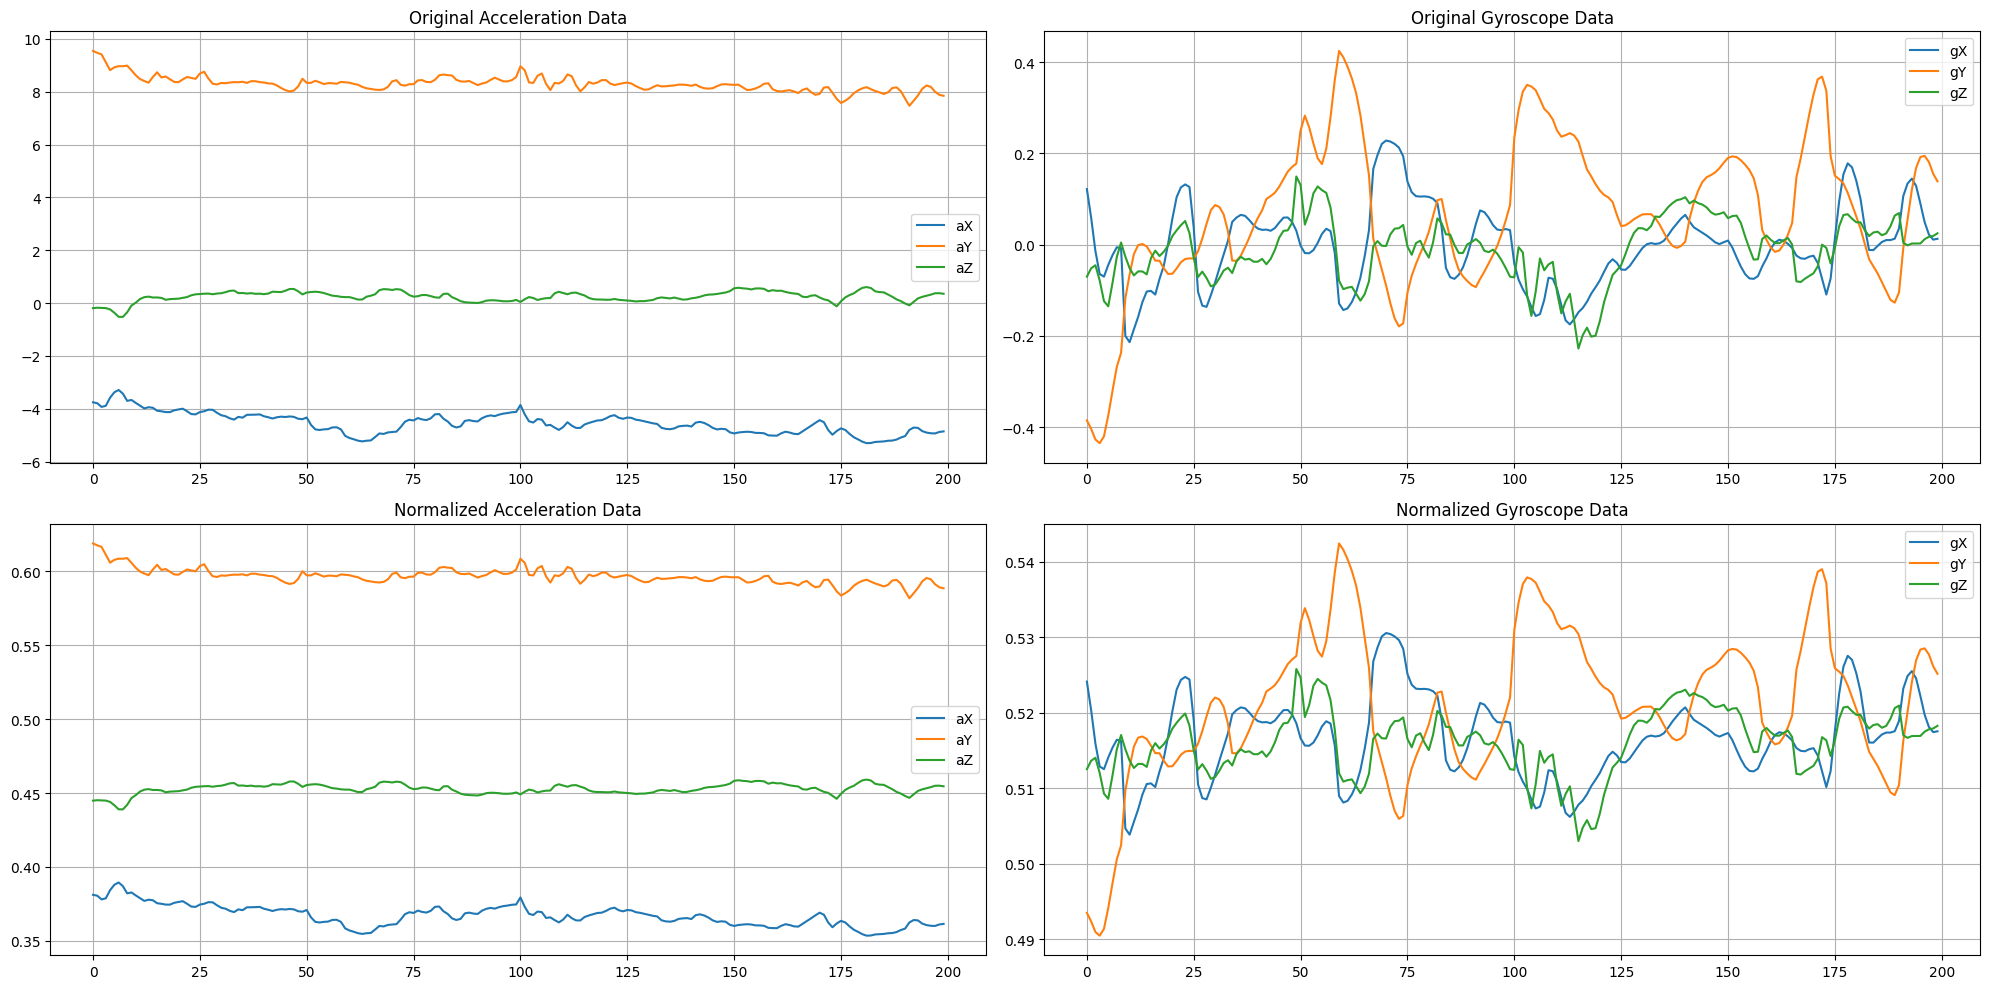


Sample 28 - Dumbbell Curl - Lift Instability


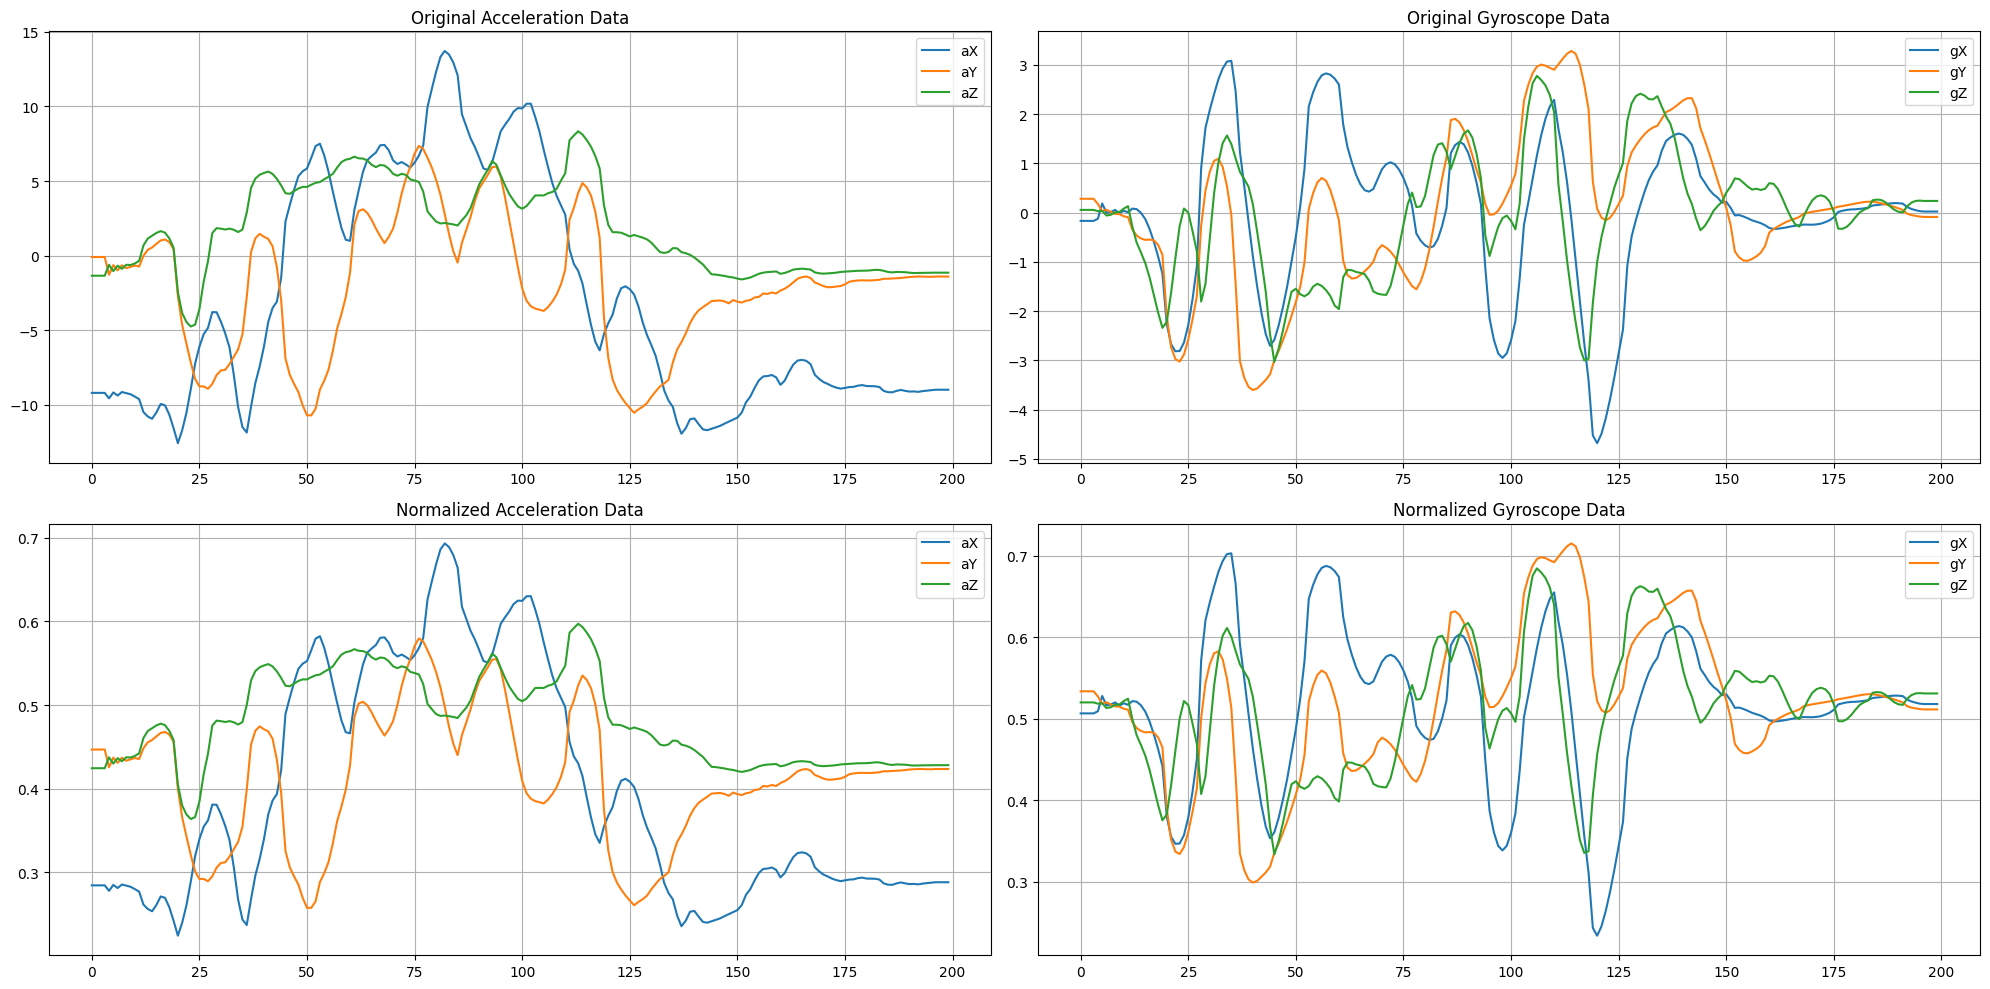


Sample 55 - Dumbbell Curl - Lift Instability


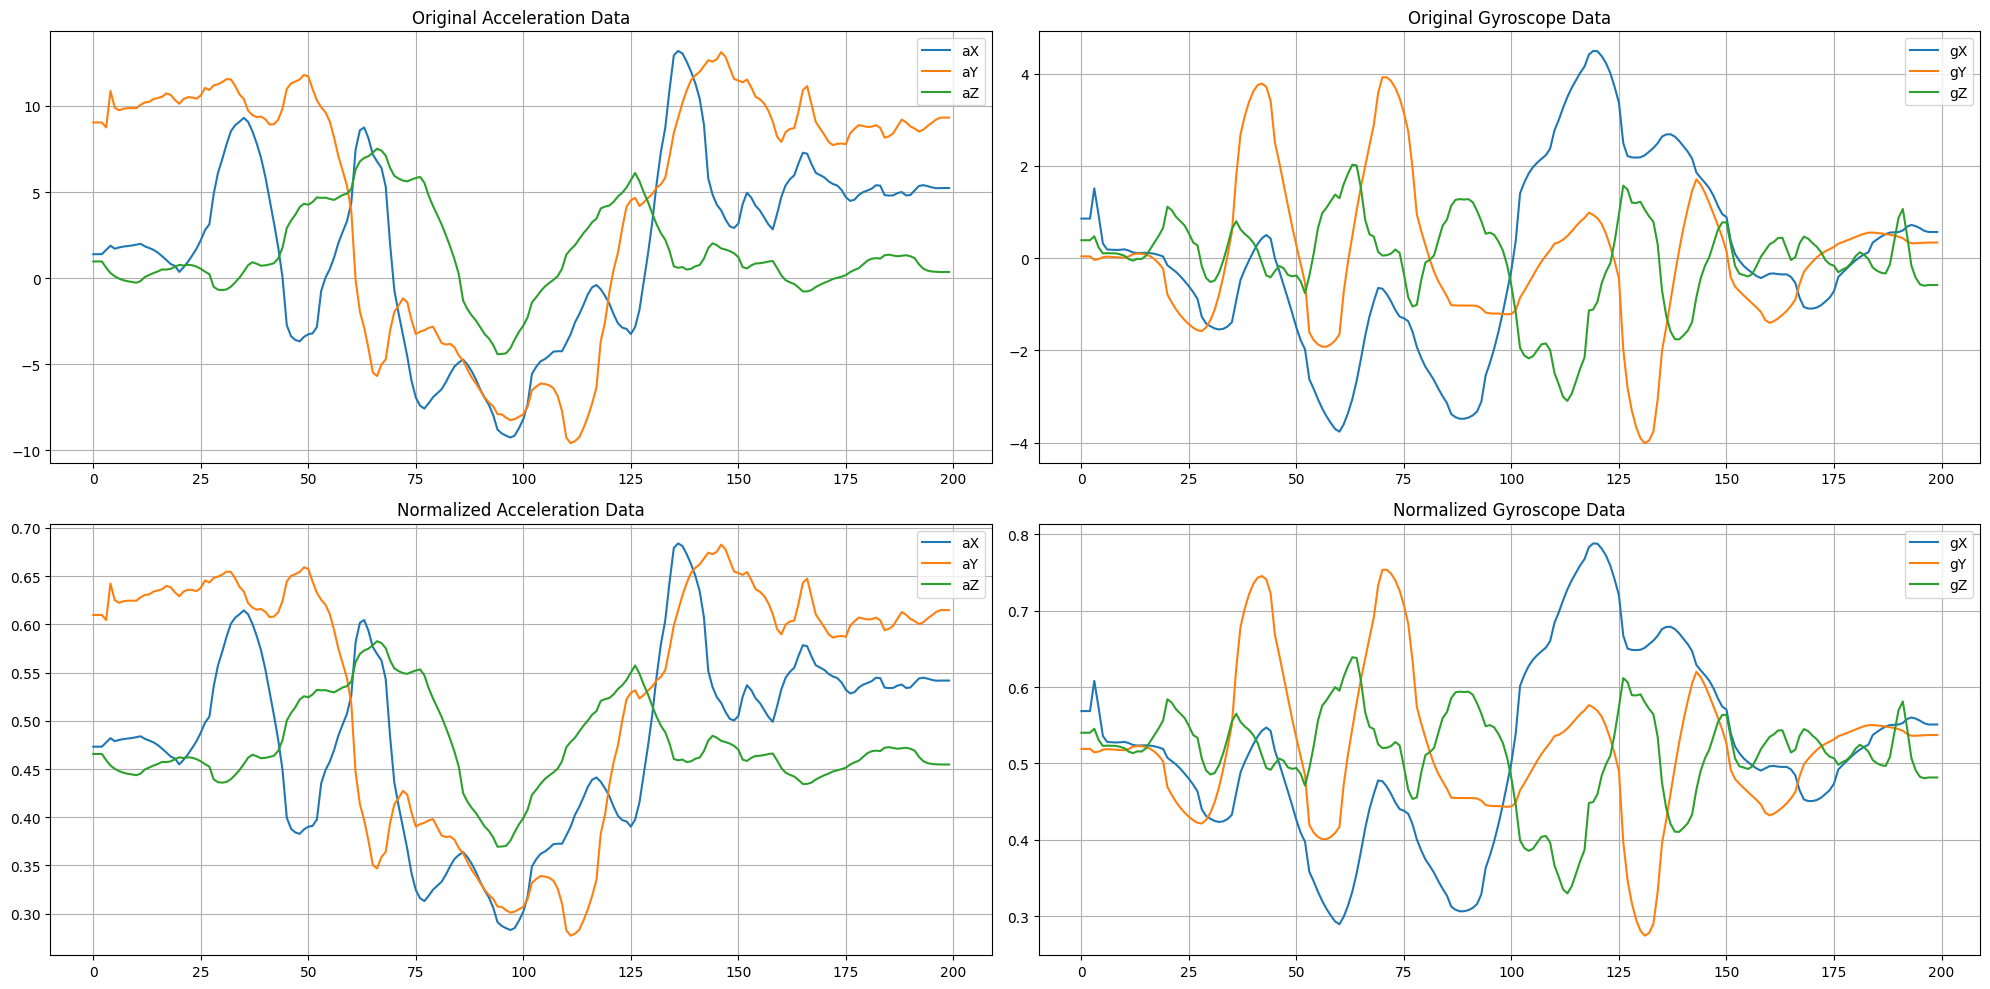


Sample 99 - Dumbbell Curl - Partial Motion


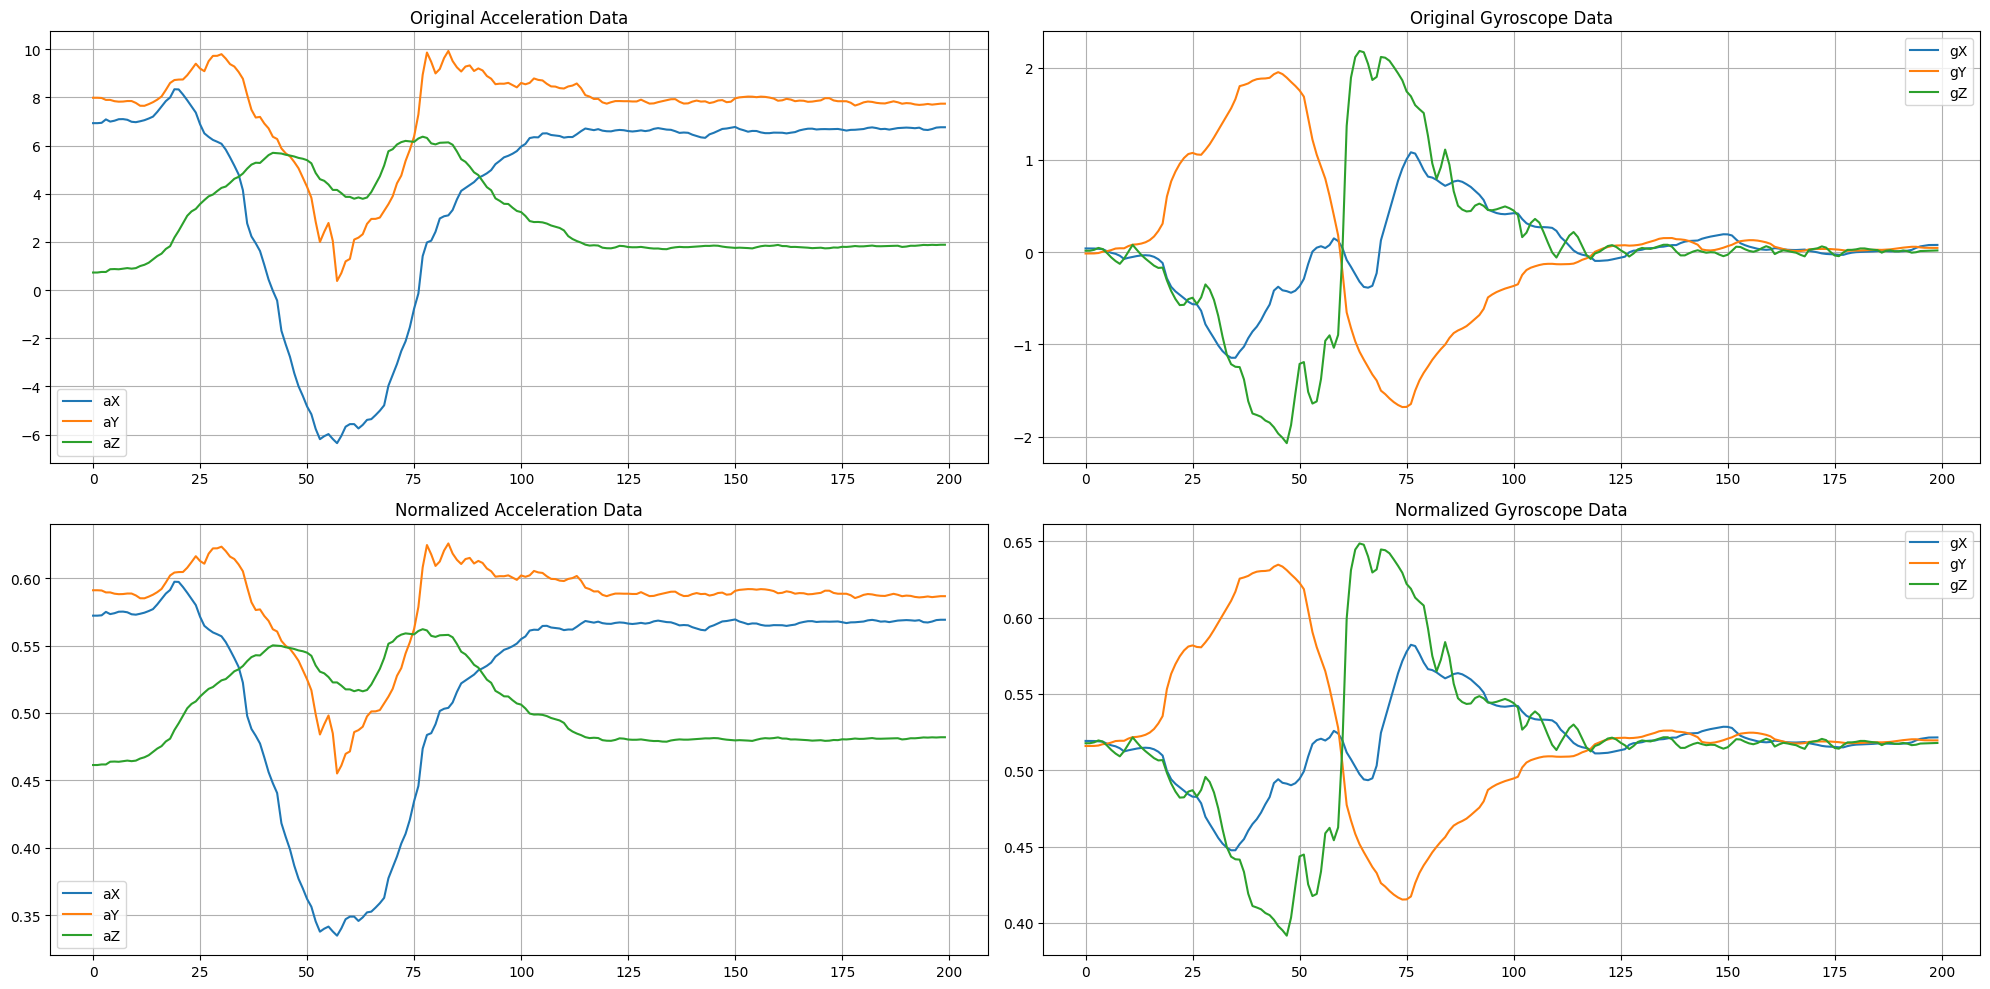


Sample 221 - Dumbbell Curl - No Lift


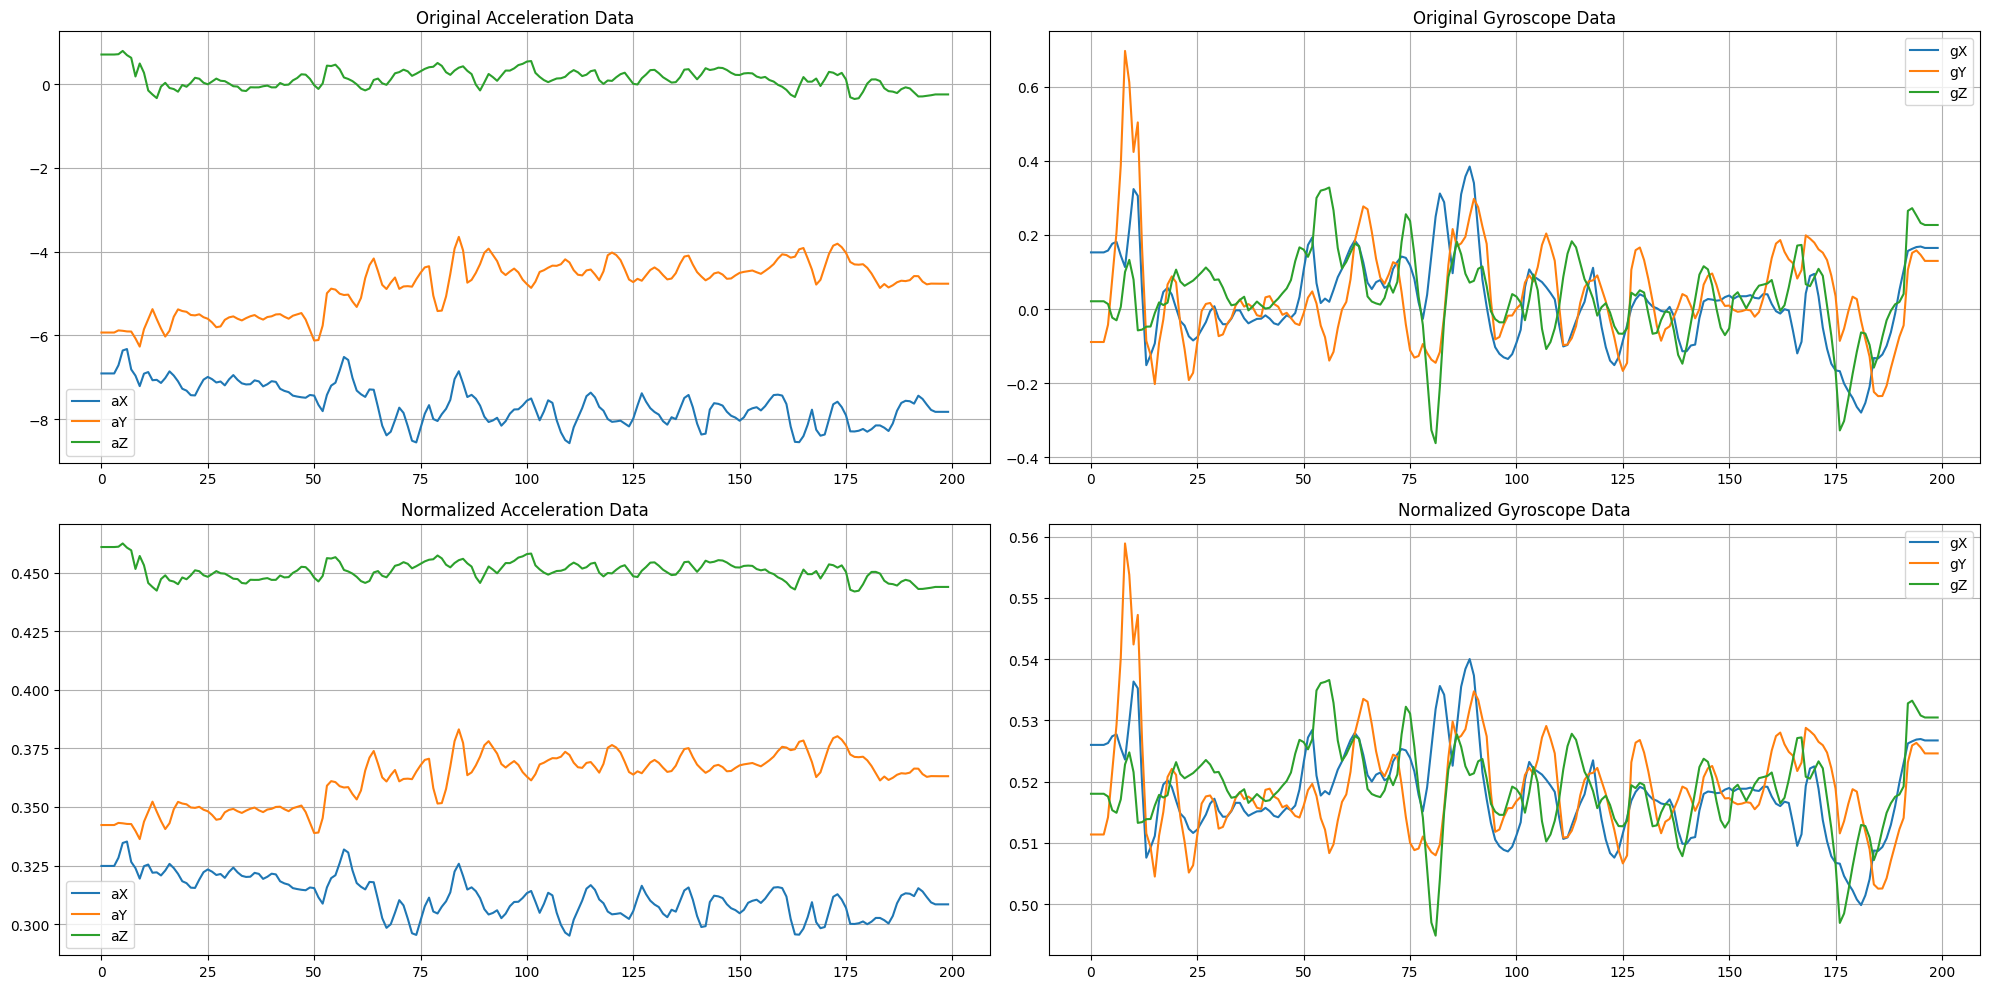


Sample 231 - Dumbbell Curl - No Lift


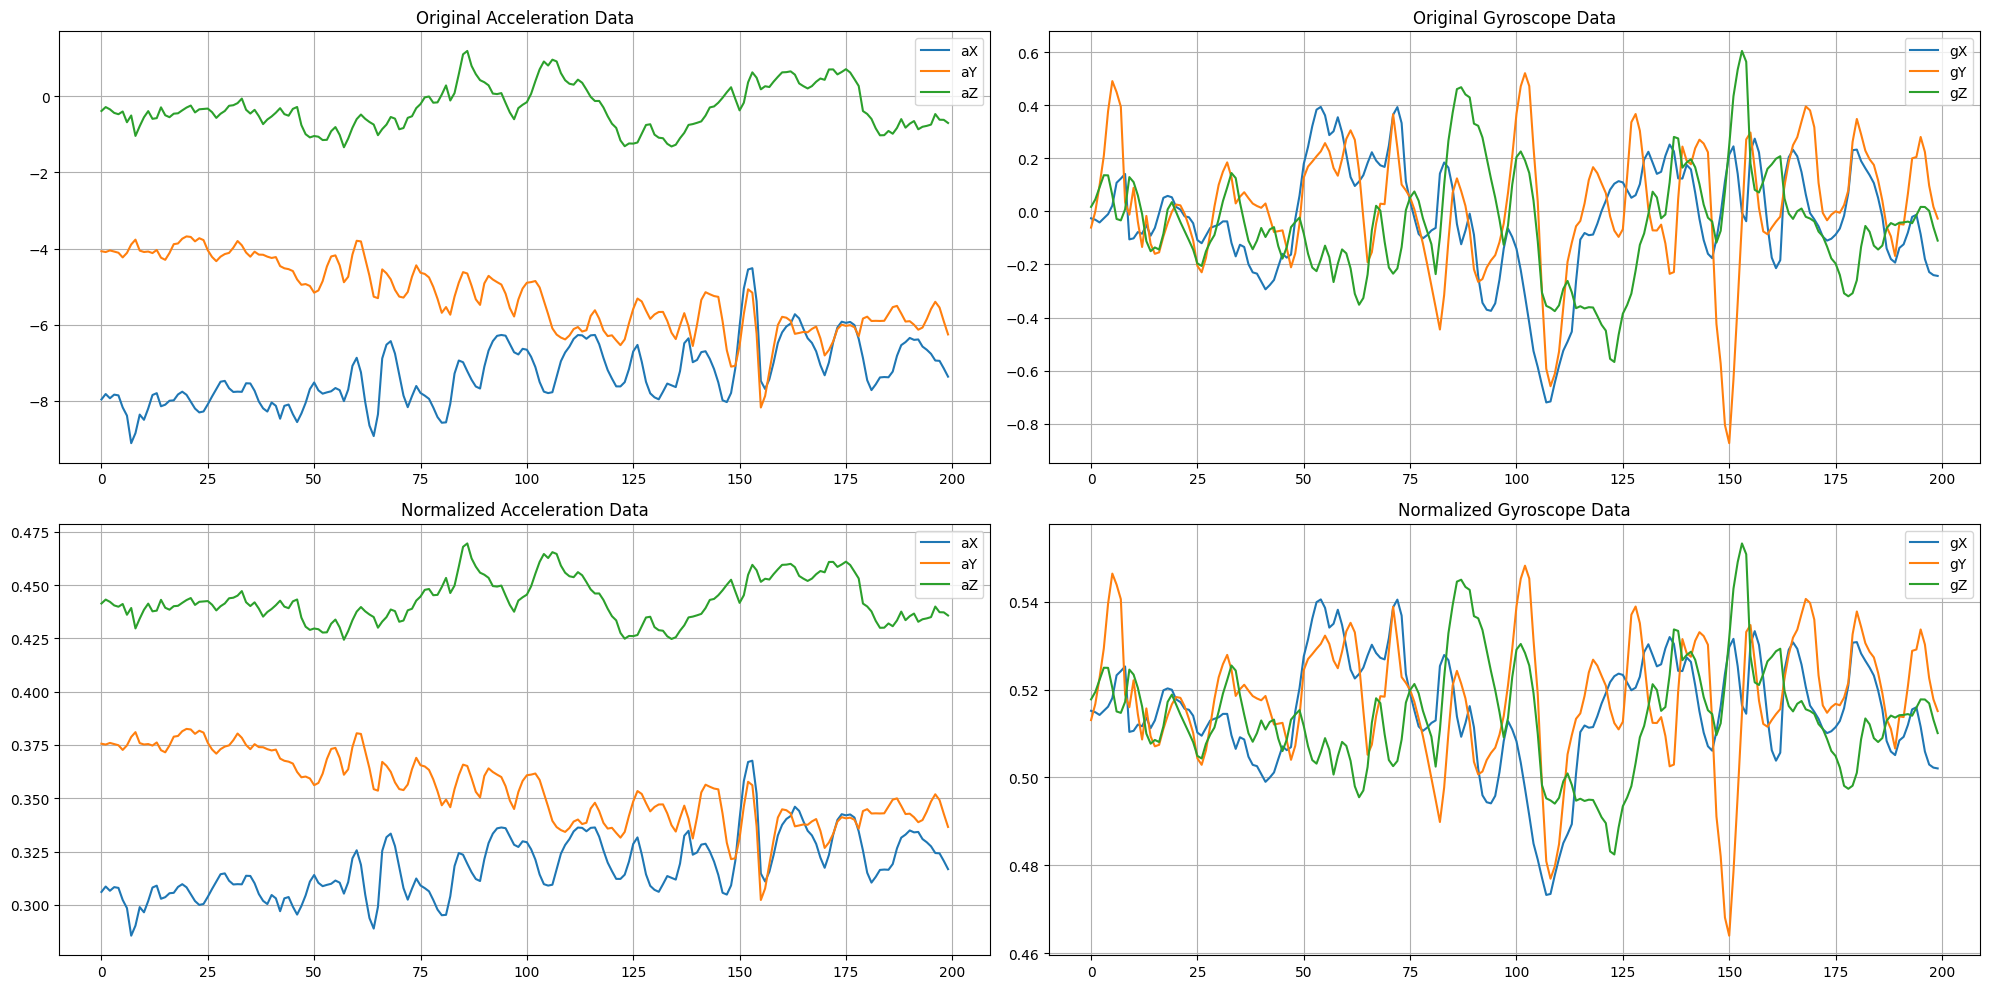

In [23]:
SHOW_NORMALIZATION = True
if SHOW_NORMALIZATION:
    # Visualize normalization for a few samples
    for i in [16, 28, 55, 99, 221, 231]:  # Show rep sample
        print(
            f"\nSample {i} - {LIFT_NAMES[DATASET[i]['lN']]} - {LIFT_CLASSES[DATASET[i]['lC']]}"
        )
        label, original_data = convert_to_array(DATASET[i])
        extended_data = extend_dataset_length(original_data, 1000)
        downsampled_data = downsample_dataset(extended_data, VECTOR_Y, "avg")
        normalized_data = normalize_sensor_data(downsampled_data, ACC_MIN, ACC_MAX, GYRO_MIN, GYRO_MAX)
        plot_normalization_comparison(downsampled_data, normalized_data)

In [24]:
print("VALIDATION DATASET")
VALIDATION_X, VALIDATION_Y = preprocess_dataset(validation_dataset, augment=False)
print("--------------------------------")
print("TEST DATASET")
TEST_X, TEST_Y = preprocess_dataset(test_dataset, augment=True)
print("--------------------------------")
print("TRAIN DATASET")
TRAIN_X, TRAIN_Y = preprocess_dataset(train_dataset, augment=True)
print("--------------------------------")

print(f"Validation: {VALIDATION_X.shape} Labels: {VALIDATION_Y.shape})")
print(f"Test: {TEST_X.shape} Labels: {TEST_Y.shape})")
print(f"Train: {TRAIN_X.shape} Labels: {TRAIN_Y.shape})")

VALIDATION DATASET
Initial class distribution: {'p_f': 8, 'o_a': 5, 'n_l': 10, 'p_m': 10, 's_w': 7, 'l_i': 19}
Final class distribution: {'p_f': 5, 'o_a': 5, 'n_l': 5, 'p_m': 5, 's_w': 5, 'l_i': 5}
Shape Checks:
X shape: (30, 200, 6)
y shape: (30,)
Number of unique labels: 6
--------------------------------
TEST DATASET
Initial class distribution: {'s_w': 6, 'p_m': 5, 'l_i': 3, 'p_f': 6, 'o_a': 5, 'n_l': 4}
Final class distribution: {'s_w': 12, 'p_m': 12, 'l_i': 12, 'p_f': 12, 'o_a': 12, 'n_l': 12}
Shape Checks:
X shape: (72, 200, 6)
y shape: (72,)
Number of unique labels: 6
--------------------------------
TRAIN DATASET
Initial class distribution: {'p_f': 34, 's_w': 36, 'o_a': 37, 'p_m': 33, 'l_i': 26, 'n_l': 44}
Final class distribution: {'p_f': 88, 's_w': 88, 'o_a': 88, 'p_m': 88, 'l_i': 88, 'n_l': 88}
Shape Checks:
X shape: (528, 200, 6)
y shape: (528,)
Number of unique labels: 6
--------------------------------
Validation: (30, 200, 6) Labels: (30,))
Test: (72, 200, 6) Labels: (72

In [25]:
def plot_feature_distribution(data, labels):
    first_sample = data[0] 
    first_label = labels[0] 

    # Create a figure with two subplots to visualize the distribution of features
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Plot values for acceleration features (0:3)
    axes[0].plot(first_sample[:, 0], marker="o", label="aX")
    axes[0].plot(first_sample[:, 1], marker="o", label="aY")
    axes[0].plot(first_sample[:, 2], marker="o", label="aZ")
    axes[0].set_title("Acceleration Features")
    axes[0].legend()
    axes[0].grid(True)

    # Plot values for gyroscope features (3:6)
    axes[1].plot(first_sample[:, 3], marker="o", label="gX")
    axes[1].plot(first_sample[:, 4], marker="o", label="gY")
    axes[1].plot(first_sample[:, 5], marker="o", label="gZ")
    axes[1].set_title("Gyroscope Features")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Call the function gated by an if statement
SHOW_FEATURE_PLOT = False
if SHOW_FEATURE_PLOT:
    plot_feature_distribution(VALIDATION_X, VALIDATION_Y)

In [26]:
# Inference Label Output
labels = sorted((set(TRAIN_Y)))
labelToInt = {}
currInt = 0
for label in labels:
    labelToInt[label] = currInt
    currInt = currInt + 1
intToLabel = {v: k for k, v in labelToInt.items()}
print(intToLabel)

{0: 'l_i', 1: 'n_l', 2: 'o_a', 3: 'p_f', 4: 'p_m', 5: 's_w'}


In [27]:
def gather_input_range(dataset):
  min_val = float('inf')
  max_val= -float('inf')
  for data in dataset:
    min_val = min(min_val, np.min(data))
    max_val = max(max_val, np.max(data))
  return min_val, max_val

min_val, max_val = gather_input_range(TRAIN_X)
print(f"Min: {min_val}, Max: {max_val}")

Min: 0.09083405908755945, Max: 0.9007956385612488


In [28]:
intToLabel.values()

dict_values(['l_i', 'n_l', 'o_a', 'p_f', 'p_m', 's_w'])

In [29]:
# One Hot Encoding of Labels
TEST_Y_cat = tf.keras.utils.to_categorical([labelToInt[y] for y in TEST_Y])
VALIDATION_Y_cat = tf.keras.utils.to_categorical([labelToInt[y] for y in VALIDATION_Y])
TRAIN_Y_cat = tf.keras.utils.to_categorical([labelToInt[y] for y in TRAIN_Y])

# Define Batch Size
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 256
AUTO = tf.data.AUTOTUNE

# Create tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((TRAIN_X, TRAIN_Y_cat))
val_ds = tf.data.Dataset.from_tensor_slices((VALIDATION_X, VALIDATION_Y_cat))
test_ds = tf.data.Dataset.from_tensor_slices((TEST_X, TEST_Y_cat))

train_ds = (
    train_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(AUTO)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(AUTO)


for x, y in train_ds.take(1):
    print(x.shape, y.shape)

# The OUT_OF_RANGE error is OKAY.

(128, 200, 6) (128, 6)


2024-12-08 18:00:42.393583: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-08 18:00:42.393960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model Definition


In [30]:
INPUT_SHAPE = (VECTOR_Y, VECTOR_X)


base_layer_size = 16
kernel_size = 4

def create_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv1D(base_layer_size, kernel_size=kernel_size, padding="same")(inputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv1D(base_layer_size , kernel_size=kernel_size, padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv1D(base_layer_size * 2, kernel_size=kernel_size * 2, padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(base_layer_size * 4, kernel_size=kernel_size * 4, padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(base_layer_size * 4)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(base_layer_size * 2)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

model = create_model()

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 16)        │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 16)        │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 32)         │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,08

 Total params: 45,094 (176.15 KB)

 Trainable params: 44,966 (175.65 KB)

 Non-trainable params: 128 (512.00 B)

In [32]:
%load_ext tensorboard

In [33]:
# Calculate steps per epoch
steps_per_epoch = len(train_ds)

# Define learning rate parameters
initial_learning_rate = 0.001
warmup_epochs = 50
warmup_steps = warmup_epochs * steps_per_epoch
first_decay_epochs = 500
first_decay_steps = first_decay_epochs * steps_per_epoch

# Cosine Decay with Warmup schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps=first_decay_steps,
    t_mul=2,  # Each restart cycle will be 1.5x longer than the previous
    m_mul=0.98,  # Each restart will have 0.95x the max learning rate of the previous
    alpha=0.2,  # Minimum learning rate will be 10% of initial
)

# Update optimizer with new schedule
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ["accuracy"]

EPOCHS = 3000  # MAKE SURE THAT THE VAL_THRESHOLD IS MET

checkpoint_filepath = os.path.join(CHKPT_DIR, "cp-{epoch:04d}.keras")
os.makedirs(CHKPT_DIR, exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

val_threshold = 0.97


class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") > val_threshold:
            print(f"\nReached {val_threshold} accuracy, stopping training!")
            self.model.stop_training = True


early_stopping_callback = EarlyStopping()

log_dir = os.path.join(LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
%tensorboard --logdir={log_dir}

In [35]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_callback, tensorboard_callback, early_stopping_callback],
)

Epoch 1/3000


2024-12-08 18:00:47.505650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.1876 - loss: 1.7728 - val_accuracy: 0.2333 - val_loss: 1.7897
Epoch 2/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3895 - loss: 1.5210 - val_accuracy: 0.1667 - val_loss: 1.7881
Epoch 3/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4266 - loss: 1.4096 - val_accuracy: 0.2667 - val_loss: 1.7861
Epoch 4/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4481 - loss: 1.3168 - val_accuracy: 0.2667 - val_loss: 1.7847
Epoch 5/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5621 - loss: 1.1663 - val_accuracy: 0.3000 - val_loss: 1.7821
Epoch 6/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6136 - loss: 0.9951 - val_accuracy: 0.2667 - val_loss: 1.7769
Epoch 7/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.6466 - loss: 0.8814 - val_accuracy: 0.3333 - val_loss: 1.7682
Epoch 8/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6903 - loss: 0.8084 - val_accuracy: 0.3000 - val_loss: 

In [36]:
# Export the model
model.export(f"{SAVED_MODEL_FILENAME}")


INFO:tensorflow:Assets written to: initial_model/models/rep_mate.keras/assets


INFO:tensorflow:Assets written to: initial_model/models/rep_mate.keras/assets


Saved artifact at 'initial_model/models/rep_mate.keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  13251127152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251126448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251124512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251124160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251127504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251131904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251124336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251292928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251285888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251293984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13251296976: TensorSpec(shape=(), dtype=

## Quantization

In [37]:
SKIP_QUANTIZATION = True

In [38]:
# Save a non quantized model
converter = tf.lite.TFLiteConverter.from_saved_model(f"{SAVED_MODEL_FILENAME}")
model_no_quant_tflite = converter.convert()

# Create interpreter to get input/output details
interpreter = tf.lite.Interpreter(model_content=model_no_quant_tflite)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Get detailed input information
for input in input_details:
    print("\nInput Details:")
    print(f"- Name: {input['name']}")
    print(f"- Shape: {input['shape']}")
    print(f"- Type: {input['dtype']}")
    print(f"- Quantization: {input['quantization']}")

for output in output_details:
    print("\nOutput Details:")
    print(f"- Name: {output['name']}")
    print(f"- Shape: {output['shape']}")
    print(f"- Type: {output['dtype']}")
    print(f"- Quantization: {output['quantization']}")

with open(FLOAT_TFL_MODEL_FILENAME, "wb") as f:
    f.write(model_no_quant_tflite)


Input Details:
- Name: serving_default_keras_tensor:0
- Shape: [  1 200   6]
- Type: <class 'numpy.float32'>
- Quantization: (0.0, 0)

Output Details:
- Name: StatefulPartitionedCall_1:0
- Shape: [1 6]
- Type: <class 'numpy.float32'>
- Quantization: (0.0, 0)


W0000 00:00:1733698931.304210 17243245 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1733698931.304751 17243245 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-12-08 18:02:11.307302: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: initial_model/models/rep_mate.keras
2024-12-08 18:02:11.308261: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-12-08 18:02:11.308267: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: initial_model/models/rep_mate.keras
2024-12-08 18:02:11.324398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-12-08 18:02:11.326349: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2024-12-08 18:02:11.392701: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: initial_model/models/rep_mate.keras
2024-1

In [39]:
if not SKIP_QUANTIZATION:
    def representative_dataset():
        unique_samples = np.unique(TRAIN_X, axis=0)
        for sample in unique_samples:
                yield [sample.astype(np.float32)]


    converter = tf.lite.TFLiteConverter.from_saved_model(f"{SAVED_MODEL_FILENAME}")
        
    # Basic optimization settings
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Force full INT8 quantization
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
        tf.lite.OpsSet.TFLITE_BUILTINS,
    ]

    # Representative dataset is required for full integer quantization
    converter.representative_dataset = representative_dataset

    # Force input/output to be INT8
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    # Enable full integer quantization
    converter.full_integer_quantization = True

    # Metal-specific settings
    converter._experimental_disable_per_channel = True
    converter.target_spec.supported_types = [tf.int8]

    # Convert model
    model_tflite = converter.convert()

    with open(QUANTIZED_TFL_MODEL_FILENAME, "wb") as f:
        f.write(model_tflite)

In [40]:
# Compare model sizes
def get_dir_size(dir_path):
    total_size = 0
    for dirpath, _, filenames in os.walk(dir_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size


# Calculate sizes
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
if not SKIP_QUANTIZATION:
    size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Create comparison DataFrame
size_comparison = pd.DataFrame(
    {
        "Model": ["TensorFlow", "TensorFlow Lite", "TensorFlow Lite Quantized"],
        "Size": [
            f"{size_tf:,} bytes",
            f"{size_no_quant_tflite:,} bytes",
            f"{size_tflite:,} bytes" if not SKIP_QUANTIZATION else "N/A",
        ],
        "Reduction": [
            "",
            f"(reduced by {size_tf - size_no_quant_tflite:,} bytes)",
            f"(reduced by {size_no_quant_tflite - size_tflite:,} bytes)" if not SKIP_QUANTIZATION else "",
        ],
    }
).set_index("Model")

# Display comparison
size_comparison

,Size,Reduction
Model,,
TensorFlow,"547,482 bytes",
TensorFlow Lite,"192,344 bytes","(reduced by 355,138 bytes)"
TensorFlow Lite Quantized,N/A,


In [41]:
def check_tflite_model(tflite_model_path):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print("== Input Details ==")
    for detail in input_details:
        print(f"Name: {detail['name']}")
        print(f"Shape: {detail['shape']}")
        print(f"Type: {detail['dtype']}")
        print(f"Quantization: {detail['quantization']}")
        print()

    print("== Output Details ==")
    for detail in output_details:
        print(f"Name: {detail['name']}")
        print(f"Shape: {detail['shape']}")
        print(f"Type: {detail['dtype']}")
        print(f"Quantization: {detail['quantization']}")
        print()

    # Print model size
    print(f"Model Size: {os.path.getsize(tflite_model_path) / 1024:.2f} KB")


# Check both models
print("=== Float Model ===")
check_tflite_model(FLOAT_TFL_MODEL_FILENAME)
if not SKIP_QUANTIZATION:
    print("\n=== Quantized Model ===")
    check_tflite_model(QUANTIZED_TFL_MODEL_FILENAME)

=== Float Model ===
== Input Details ==
Name: serving_default_keras_tensor:0
Shape: [  1 200   6]
Type: <class 'numpy.float32'>
Quantization: (0.0, 0)

== Output Details ==
Name: StatefulPartitionedCall_1:0
Shape: [1 6]
Type: <class 'numpy.float32'>
Quantization: (0.0, 0)

Model Size: 187.84 KB


## Test Models

In [42]:
def evaluate_models():

    def run_tflite_inference(interpreter, input_data, is_quantized=False, debug=False):
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Debug: Print input details
        if debug:
            print(f"Input details: {input_details}")
            print(f"Output details: {output_details}")

        input_data = input_data.numpy()

        # Handle input scaling for quantized model
        if is_quantized:
            input_scale = input_details[0]["quantization"][0]
            input_zero_point = input_details[0]["quantization"][1]
            input_data = input_data / input_scale + input_zero_point
            input_data = input_data.astype(np.int8)
        else:
            input_data = input_data.astype(np.float32)

        predictions = []
        input_data_reshaped = input_data.reshape(
            (-1,) + tuple(input_details[0]["shape"][1:])
        )

        # Process batches
        for i in range(input_data_reshaped.shape[0]):
            sample = input_data_reshaped[i : i + 1]
            interpreter.set_tensor(input_details[0]["index"], sample)
            interpreter.invoke()
            output = interpreter.get_tensor(output_details[0]["index"])

            # Dequantize output if needed
            if is_quantized:
                output_scale = output_details[0]["quantization"][0]
                output_zero_point = output_details[0]["quantization"][1]
                output = (output.astype(np.float32) - output_zero_point) * output_scale

            predictions.append(output[0])

        return np.array(predictions)

    def calculate_metrics(y_true, y_pred, class_names):
        """
        Calculates classification metrics with proper handling of class names.
        Args:
            y_true: True labels
            y_pred: Predicted labels
            class_names: Dictionary mapping class indices to names
        Returns:
            Tuple of (accuracy, precision, recall, f1)
        """
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", labels=list(class_names.keys())
        )
        return accuracy, precision, recall, f1

    # Initialize results dictionary
    results = {}
    y_true = np.argmax(TEST_Y_cat, axis=1)

    # Test each model variant
    models_to_test = [
        ("TensorFlow", None, False, True),
        ("TFLite Float", FLOAT_TFL_MODEL_FILENAME, False, True),
        # ("TFLite Quantized", QUANTIZED_TFL_MODEL_FILENAME, True, True),
    ]

    for model_name, model_path, is_quantized, debug in models_to_test:
        print(f"\nTesting {model_name}...")

        if model_name == "TensorFlow":
            # Handle TensorFlow model
            predictions = []
            for x, _ in test_ds:
                pred = model.predict(x, verbose=0)
                predictions.extend(pred)
        else:
            # Handle TFLite models
            interpreter = tf.lite.Interpreter(model_path=model_path)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            print("Quantization parameters:", input_details[0]["quantization"])

            predictions = []
            for x, _ in test_ds:
                pred_batch = run_tflite_inference(interpreter, x, is_quantized, debug)
                predictions.extend(pred_batch)

        predictions = np.array(predictions)
        pred_classes = np.argmax(predictions, axis=1)
        metrics = calculate_metrics(y_true, pred_classes, intToLabel)

        # Store results
        results[model_name] = {
            "accuracy": metrics[0],
            "precision": metrics[1],
            "recall": metrics[2],
            "f1": metrics[3],
        }

        # Print class distribution
        print(f"\n{model_name} Prediction Distribution:")
        unique, counts = np.unique(pred_classes, return_counts=True)
        for class_idx, count in zip(unique, counts):
            class_name = intToLabel.get(class_idx, f"Unknown ({class_idx})")
            print(f"{class_name}: {count} predictions")

    # Create comparison DataFrame
    return pd.DataFrame(
        {
            "Model": list(results.keys()),
            "Accuracy": [f"{results[model]['accuracy']*100:.2f}%" for model in results],
            "Precision": [
                f"{results[model]['precision']*100:.2f}%" for model in results
            ],
            "Recall": [f"{results[model]['recall']*100:.2f}%" for model in results],
            "F1 Score": [f"{results[model]['f1']*100:.2f}%" for model in results],
        }
    ).set_index("Model")


model_comparison = evaluate_models()
model_comparison


Testing TensorFlow...

TensorFlow Prediction Distribution:
l_i: 12 predictions
n_l: 12 predictions
o_a: 12 predictions
p_f: 12 predictions
p_m: 14 predictions
s_w: 10 predictions

Testing TFLite Float...
Quantization parameters: (0.0, 0)
Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1, 200,   6], dtype=int32), 'shape_signature': array([ -1, 200,   6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 67, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {

2024-12-08 18:02:12.307529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 18:02:12.315972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,Accuracy,Precision,Recall,F1 Score
Model,,,,
TensorFlow,97.22%,97.62%,97.22%,97.20%
TFLite Float,97.22%,97.62%,97.22%,97.20%


## Generate TFLite Model

In [43]:
MODEL_TO_CONVERT = QUANTIZED_TFL_MODEL_FILENAME if not SKIP_QUANTIZATION else FLOAT_TFL_MODEL_FILENAME

In [44]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TO_CONVERT} > {TFL_CC_MODEL_FILENAME}

REPLACE_TEXT = MODEL_TO_CONVERT.replace('/', '_').replace('.', '_')
!sed -i '' 's/'{REPLACE_TEXT}'/g_rep_mate_model_data/g' {TFL_CC_MODEL_FILENAME}

In [45]:
!cat {TFL_CC_MODEL_FILENAME}

unsigned char g_rep_mate_model_data[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00, 0x30, 0xc5, 0x02, 0x00,
  0x40, 0xc5, 0x02, 0x00, 0x88, 0xee, 0x02, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x9a, 0x33, 0xfd, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x43, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x6f, 0x75, 0x74, 0x70,
  0x75, 0x74, 0x5f, 0x30, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x3a, 0x3a, 0xfd, 0xff, 0x04, 0x00, 0x00, 0x

In [46]:
!tail {TFL_CC_MODEL_FILENAME}


  0xbc, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x28,
  0xc8, 0xff, 0xff, 0xff, 0x12, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x12,
  0xd4, 0xff, 0xff, 0xff, 0x11, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x11,
  0x04, 0x00, 0x04, 0x00, 0x04, 0x00, 0x00, 0x00, 0xe8, 0xff, 0xff, 0xff,
  0x16, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x16, 0xf4, 0xff, 0xff, 0xff,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03, 0x0c, 0x00, 0x0c, 0x00,
  0x0b, 0x00, 0x00, 0x00, 0x00, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x46, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x46
};
unsigned int g_rep_mate_model_data_len = 192344;
